# Shelter Animal Outcomes

In this notebook we will try to predict the future of the animals that get into shelters.

In [1]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import collections
import sklearn.base
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline


%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
display(train.head(),
        train.isnull().sum(),
        test.isnull().sum())

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

In [4]:
train.loc[train['SexuponOutcome'].isnull(), 'SexuponOutcome'] = 'Unknown'

/home/god/py/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


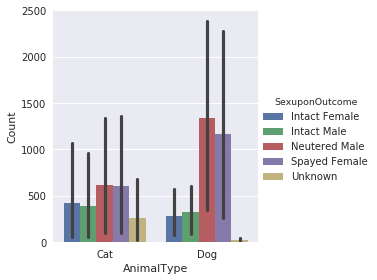

In [5]:
animal_sex_outcomes = train.groupby(['AnimalType', 'SexuponOutcome']).OutcomeType.value_counts()
animal_sex_outcomes.name = 'Count'
animal_sex_outcomes = animal_sex_outcomes.reset_index()
a_s_o_fp = sns.factorplot(x='AnimalType',
                          y='Count',
                          hue='SexuponOutcome',
                          data=animal_sex_outcomes,
                          kind='bar',)

In [6]:
train_id, test_id = train['AnimalID'], test['ID']
# train.drop('AnimalID', axis=1, inplace=True)
# test.drop('ID', axis=1, inplace=True)

In [7]:
class SimpleAnimalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # print('[I] Engineering simple features')
        sterilized_pat = re.compile('.*(neutered|spayed).*', re.IGNORECASE)
        female_pat = re.compile('.*\\b(female)\\b.*', re.IGNORECASE)  
        male_pat = re.compile('.*\\b(male)\\b.*', re.IGNORECASE)
        
        X = X.copy()
        X.loc[:,'Sterilized'] = 1 * X['SexuponOutcome'].str.match(sterilized_pat).fillna(0)   
        def transform_sex(sex):
            if isinstance(sex, str):
                if male_pat.match(sex):
                    return 1
                elif female_pat.match(sex):
                    return 2
            return 0
        X.loc[:, 'SexuponOutcome'] = X['SexuponOutcome'].transform(transform_sex)
        X.loc[:, 'Name'] = 1 * X['Name'].notnull()
        return X

In [8]:
breedcnt = dict()

breed_noise_pat = re.compile('\\s*\\b(mix|shorthair|australian|swiss|mexican|' +
                             'spanish|american|british|english|belgian|jack|russel|l|old|' +
                             'west|german|rat|great|shorthair|longhair|mediumhair|eng|toy|' +
                             'medium|hair|russel|yorkshire|miniature|pale|gray|red|' +
                             'orange|tiger|smoke|blue|yellow|tabby|calico|point|tick|brindle|' +
                             'tan|black|)\\b\\s*', re.IGNORECASE)

def simplify_breed(breed):
    return breed_noise_pat.sub('', breed)

def breed_is_(breed, pat):
    def clf(x):
        return 1 * x['Breed'].str.match(pat)
    return clf

breed_props = [('Domestic', re.compile('.*domestic.*', re.IGNORECASE),),
               ('Longhair', re.compile('.*long\\s*hair.*', re.IGNORECASE),),
               ('Mix', re.compile('.*(mix|/).*', re.IGNORECASE))]

class BreedPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_breeds=6, col='Breed', rare='Rare'):
        self.max_breeds = max_breeds
        self.col = col
        self.rare = rare
        self.breed_cnt_ = None
        
    def fit(self, X, y=None):
        # print('[I] Fitting breeds')
        breedcnt = defaultdict(lambda: 0)
        for breeds in X[self.col]:
            for breed in breeds.split('/'):
                breed = simplify_breed(breed)
                breedcnt[breed] += 1
        self.breed_cnt_ = pd.Series(breedcnt).sort_values(ascending=False)
        self.top_ = set(self.breed_cnt_.index[:self.max_breeds - 1])
        return self
    
    def _extract_breed(self, breeds):
        for breed in breeds.split('/'):
            breed = simplify_breed(breed)
            if breed in self.top_:
                return breed
        return self.rare
    
    def transform(self, X):
        # print('[I] Transforming breeds')
        X = X.copy()
        X[self.col] = X[self.col].apply(lambda x: self._extract_breed(x))
        X = X.assign(**{
            breed_prop: breed_is_(breed_prop, pat)
            for breed_prop, pat in breed_props
        })
        return X
        
breeds = BreedPreprocessor()
breeds.fit(pd.concat((train, test)))
breeds.top_

{'Chihuahua', 'Domestic', 'LabradorRetriever', 'PitBull', 'Shepherd'}

In [9]:
breeds

BreedPreprocessor(col='Breed', max_breeds=6, rare='Rare')

In [10]:


# TODO:
# 1.  extract "basic" colors
# 2.  treat space-separated basic colors as polycolored patterns
def is_monocolor(x):
    return x['Color'].str.contains('/')

class ColorPreprocessor(BaseEstimator):
    def __init__(self, max_colors=5, col='Color'):
        self.max_colors = max_colors
        self.col = col
        self.color_cnt_ = None
        self.top_ = None
    def fit(self, X, y=None):
        # print('[I] Fitting colors')
        clrcnt = defaultdict(lambda: 0)
        for clrs in X[self.col]:
            for clr in clrs.split('/'):
                clrcnt[clr] += 1
        self.color_cnt_ = pd.Series(clrcnt).sort_values(ascending=False)
        self.top_ = set(self.color_cnt_.index[:self.max_colors-1])
        return self
        
    def _extract_color(self, colors):
        for color in colors.split('/'):
            color = simplify_breed(color)
            if color in self.top_: return color
        return 'Rare'
    
    def transform(self, X):
        # print('[I] Transforming colors')
        X = X.copy()
        X = X.assign(Monocolor = is_monocolor)
        X[self.col] = X[self.col].apply(self._extract_color)
        return X
        
colors = ColorPreprocessor()
colors.fit(pd.concat((train, test)))
colors.top_

{'Black', 'Brown', 'Tan', 'White'}

In [11]:
adopted = breeds.transform(train).loc[breeds.transform(train)['OutcomeType'] == 'Adoption']
adopted.groupby(['AnimalType', 'Breed'])['AgeuponOutcome'].describe()

count unique       top  freq
AnimalType Breed                                         
Cat        Domestic           3927     28  2 months  1691
           Rare                345     27  2 months   108
Dog        Chihuahua          1192     26    1 year   273
           LabradorRetriever   980     24  2 months   203
           PitBull             669     22    1 year   173
           Rare               3136     27    1 year   630
           Shepherd            520     24  2 months    95

In [12]:
died = breeds.transform(train).loc[breeds.transform(train)['OutcomeType'] == 'Died']
died.groupby(['AnimalType', 'Breed'])['AgeuponOutcome'].describe()

count unique       top freq
AnimalType Breed                                        
Cat        Domestic            139     26   1 month   42
           Rare                  8      6   1 month    3
Dog        Chihuahua            16     11   2 years    3
           LabradorRetriever     4      3  10 years    2
           PitBull               8      7  3 months    2
           Rare                 19     13   2 years    4
           Shepherd              3      3   2 years    1

In [13]:
def age_to_ymd(x):
    if x <= 30:
        return (0, 0, x)
    elif x < 365:
        return (0, x//30, 0)
    else:
        return (int(x/365.25), 0, 0)

def purify_ages(ages):
    days_in_unit = {
    'day': 1,
    'days': 1,
    'week': 7,
    'weeks': 7,
    'month': 30,
    'months': 30,
    'years': 365.25,
    'year': 365.25
    }
    def strage_to_days(age):
        if not isinstance(age, str):
            return float('nan')
        age = age.split(' ')
        return int(age[0]) * days_in_unit[age[1]]
    ages = ages.map(strage_to_days)
    return ages


class AgePreprocessor(BaseEstimator):
    def __init__(self,
                 col='AgeuponOutcome',
                 groupby=['Breed', 'SexuponOutcome',],
                 max_breeds=20,
                 estimator=np.mean,
                 split_to_ymd=False):
        self.col = col
        self.groupby = groupby
        self.estimator = estimator
        self.max_breeds = max_breeds
        self.split_to_ymd = split_to_ymd
        
    def fit(self, X, y=None):
        bp_ = BreedPreprocessor(self.max_breeds)
        bp_.fit(X)
        self.prep_ = make_pipeline(bp_, SimpleAnimalFeatures())
        return self
    
    def transform(self, X):
        # First we remember how precise the date was specified
        specific_age_pat = re.compile('.*(week|day).*', re.IGNORECASE)
        X = X.copy()
        X.loc[:,'SpecificAge'] = X.loc[:,self.col].str.match(specific_age_pat).fillna(0)
        # X.loc[:,'SpecificAge'] = X[:,'SpecificAge'].fillna(0)
        # Then we convert them to days
        X.loc[:,self.col] = purify_ages(X[self.col])
        # And finally we impute NA's:
        X2 = self.prep_.transform(X)
        # Screw pandas! There's no natural syntax to transform
        # this thing groupwise using averages computed on the `full` dataset.
        # So let's take an easy way:
        X.loc[:,self.col] = X.loc[:,self.col].fillna(
            X2.groupby(self.groupby)[self.col]
            .transform(lambda x: x.fillna(self.estimator(x)))
        )
        X.loc[:,self.col] = X.loc[:,self.col].fillna(X2.loc[:,self.col].median())
        if self.split_to_ymd:
            X['AgeYears'], X['AgeMonths'], X['AgeDays'] = zip(
                *X.loc[:,self.col].apply(age_to_ymd)
            )
            X = X.drop('AgeuponOutcome', axis=1)
        return X
                      

ages = AgePreprocessor()
full = pd.concat((train, test), keys=(1,2))
ages.fit(full)


AgePreprocessor(col='AgeuponOutcome',
        estimator=<function mean at 0x7f87341381e0>,
        groupby=['Breed', 'SexuponOutcome'], max_breeds=20,
        split_to_ymd=False)

In [14]:
# train = ages.transform(train)
# test = ages.transform(test)
ages.transform(pd.concat((train, test)))['AgeuponOutcome'].isnull().sum()

0

In [15]:
import dateutil

In [16]:
def extract_mon_wd_h(x):
    x = dateutil.parser.parse(x)
    return (x.month, x.day, x.weekday(), x.hour)


class ArrivalDatePreprocessor(BaseEstimator):
    def __init__(self, col='DateTime'):
        self.col = col
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # print('[I] Transforming arrival dates')
        X = X.copy()
        X['ArrMonth'], X['ArrMonthday'], X['ArrWeekday'], X['ArrHour'] = (
            zip(*X[self.col].apply(extract_mon_wd_h))
        )
        return X
arrivals = ArrivalDatePreprocessor()
arrivals.fit(train)

ArrivalDatePreprocessor(col='DateTime')

In [17]:
class DropGarbage(sklearn.base.BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # print('[I] Droping crap')
        return X.drop([
            'ID', 'AnimalID',
            'DateTime',
            'OutcomeType',
            'OutcomeSubtype'],
            axis=1,
            errors='ignore')

In [18]:
class TextvarsSeqEncoder(BaseEstimator):
    def __init__(self, textvars=['AnimalType', 'Breed', 'Color']):
        self.textvars = textvars
        self.enc_ = defaultdict(sklearn.preprocessing.LabelEncoder)

    def fit(self, X, y=None):
        # print('[I] Fitting text var encoders')
        for v in self.textvars:
            self.enc_[v].fit(X[v])
        return self
    
    def transform(self, X):
        # print('[I] Encoding text vars')
        X = X.copy()
        for v in self.textvars:
            X[v] = self.enc_[v].transform(X[v])
        return X

In [19]:
class AnimalScaler(BaseEstimator):
    def __init__(self, groupby=['Breed']):
        self.groupby = groupby
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        if 'AgeDays' in X.columns:
            X.loc[X['AgeDays'] != 0, 'AgeDays'] = (
                X.loc[X['AgeDays'] != 0]
                .groupby(self.groupby)['AgeDays']
                .transform(lambda x: x/x.median())
            )
            X.loc[X['AgeMonths'] != 0, 'AgeMonths'] = (
                X.loc[X['AgeMonths'] != 0]
                .groupby(self.groupby)['AgeMonths']
                .transform(lambda x: x/x.median())
            )
            X.loc[X['AgeYears'] != 0, 'AgeYears'] = (
                X.loc[X['AgeYears'] != 0]
                .groupby(self.groupby)['AgeYears']
                .transform(lambda x: x/x.median())
            )
        X.loc[:,'ArrMonth'] /= 12
        X.loc[:,'ArrMonthday'] /= 30
        X.loc[:,'ArrWeekday'] /= 7
        X.loc[:,'ArrHour'] /= 24
        return X
        

Now let's prefill missing ages and start building a predictive model

In [20]:
train, test = pd.read_csv('train.csv'), pd.read_csv('test.csv')
ages.fit(full)
train, test = ages.transform(train), ages.transform(test)

In [21]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

In [22]:
prepr_pipe = Pipeline([
    ('breed', breeds),
    ('color', colors),
    ('arrivals', arrivals),
    ('simplefeats', SimpleAnimalFeatures()),
    ('drop', DropGarbage()),
    ('textenc', TextvarsSeqEncoder()),
    ('scale', AnimalScaler())
])

In [23]:
prepr_pipe.fit(pd.concat((train, test), keys=(1,2)))
X = prepr_pipe.transform(train)

In [24]:
X.head()

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,SpecificAge,Domestic,Longhair,Mix,Monocolor,ArrMonth,ArrMonthday,ArrWeekday,ArrHour,Sterilized
0,1,1,1,365.25,4,0,False,0,0,0,True,0.166667,0.400000,0.285714,0.750000,1
1,1,0,2,365.25,1,1,False,1,0,0,False,0.833333,0.433333,0.857143,0.500000,1
2,1,1,1,730.50,3,2,False,0,0,0,True,0.083333,1.033333,0.714286,0.500000,1
3,0,0,1,21.00,1,1,True,1,0,0,False,0.583333,0.366667,0.571429,0.791667,0
4,0,1,1,730.50,4,1,False,0,0,0,False,0.916667,0.500000,0.571429,0.500000,1


In [25]:
X.isnull().sum()

Name              0
AnimalType        0
SexuponOutcome    0
AgeuponOutcome    0
Breed             0
Color             0
SpecificAge       0
Domestic          0
Longhair          0
Mix               0
Monocolor         0
ArrMonth          0
ArrMonthday       0
ArrWeekday        0
ArrHour           0
Sterilized        0
dtype: int64

In [26]:
y = train['OutcomeType']
X_chisq_pv = pd.Series(dict(zip(X.columns, chi2(X, y)[1]))).sort_values()
display((X_chisq_pv < 5e-2).sum(),
        (X_chisq_pv < 1e-32).sum(),
        X_chisq_pv)

12

7

AgeuponOutcome     0.000000e+00
Breed              0.000000e+00
Domestic           0.000000e+00
Name               0.000000e+00
SpecificAge        0.000000e+00
Sterilized         0.000000e+00
AnimalType        1.636853e-280
Monocolor          3.347020e-31
SexuponOutcome     1.424885e-20
ArrWeekday         3.366517e-18
ArrHour            3.223293e-15
Color              1.455877e-06
ArrMonth           2.967382e-01
ArrMonthday        8.829056e-01
Longhair                    NaN
Mix                         NaN
dtype: float64

In [27]:
pipe1 = Pipeline([
    ('prepr', prepr_pipe),
    ('chi2', SelectKBest(chi2, 7)),
    # ('threshold', SelectFromModel(RandomForestClassifier(350), 2e-2)),
    ('rfc', RandomForestClassifier(350))
])
gs1 = GridSearchCV(pipe1,
                  param_grid = {
                      'chi2__k': ['all'], #[7, 12, 'all'],
                      'prepr__breed__max_breeds': [5],
                      'prepr__color__max_colors': [20],
                      'rfc__n_estimators': [800],
                  },
                  scoring='neg_log_loss',
                  n_jobs=2,
                  verbose=10,
                  cv=StratifiedKFold(3))
gs1.fit(train, train['OutcomeType'])
display(gs1,
        gs1.best_params_,
        gs1.best_score_,
        gs1.best_estimator_.steps[-1][1].feature_importances_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] chi2__k=all, prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800 
[CV] chi2__k=all, prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800 
[CV]  chi2__k=all, prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, score=-0.802221, total=  12.8s
[CV] chi2__k=all, prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800 
[CV]  chi2__k=all, prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, score=-0.813757, total=  12.8s
[CV]  chi2__k=all, prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, score=-0.791546, total=  12.2s


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   32.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   32.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('prepr', Pipeline(steps=[('breed', BreedPreprocessor(col='Breed', max_breeds=6, rare='Rare')), ('color', ColorPreprocessor(col='Color', max_colors=5)), ('arrivals', ArrivalDatePreprocessor(col='DateTime')), ('simplefeats', SimpleAnimalFeatures()), ('drop', DropGarbage()), ('textenc', Textvar...mators=350, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'chi2__k': ['all'], 'prepr__breed__max_breeds': [5], 'prepr__color__max_colors': [20], 'rfc__n_estimators': [800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=10)

{'chi2__k': 'all',
 'prepr__breed__max_breeds': 5,
 'prepr__color__max_colors': 20,
 'rfc__n_estimators': 800}

-0.80250896712029685

array([ 0.0456568 ,  0.01536564,  0.02629229,  0.17855036,  0.03652331,
        0.05558804,  0.01523383,  0.01045537,  0.        ,  0.        ,
        0.02090256,  0.10815194,  0.14509903,  0.08375413,  0.13861014,
        0.11981657])

In [28]:
display(pd.Series(dict(zip(X.columns, gs1.best_estimator_.steps[-1][1].feature_importances_))).sort_values())

Longhair          0.000000
Mix               0.000000
Domestic          0.010455
SpecificAge       0.015234
AnimalType        0.015366
Monocolor         0.020903
SexuponOutcome    0.026292
Breed             0.036523
Name              0.045657
Color             0.055588
ArrWeekday        0.083754
ArrMonth          0.108152
Sterilized        0.119817
ArrHour           0.138610
ArrMonthday       0.145099
AgeuponOutcome    0.178550
dtype: float64

In [31]:
pipe2 = Pipeline([
    ('prepr', prepr_pipe),
    ('threshold', SelectFromModel(RandomForestClassifier(350), .05)),
    ('rfc', RandomForestClassifier(350))
])
gs2 = GridSearchCV(pipe2,
                  param_grid = {
                      'prepr__breed__max_breeds': [5],
                      'prepr__color__max_colors': [20],
                      'threshold__threshold': [0.01, 0.02], # [.02, .05, .08, .1],
                      'rfc__n_estimators': [800],
                  },
                  scoring='neg_log_loss',
                  n_jobs=2,
                  verbose=10,
                  cv=StratifiedKFold(3))
gs2.fit(train, train['OutcomeType'])
display(gs2,
        gs2.best_params_,
        gs2.best_score_,
        gs2.best_estimator_.steps[-1][1].feature_importances_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, threshold__threshold=0.01 
[CV] prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, threshold__threshold=0.01 
[CV]  prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, threshold__threshold=0.01, score=-0.814628, total=  16.3s
[CV]  prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, threshold__threshold=0.01, score=-0.807580, total=  16.3s
[CV] prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, threshold__threshold=0.01 
[CV] prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, threshold__threshold=0.02 


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   20.5s


[CV]  prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, threshold__threshold=0.01, score=-0.792334, total=  17.1s
[CV] prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, threshold__threshold=0.02 
[CV]  prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, threshold__threshold=0.02, score=-0.806795, total=  17.4s
[CV] prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, threshold__threshold=0.02 


[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:   42.0s remaining:   21.0s


[CV]  prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, threshold__threshold=0.02, score=-0.813050, total=  16.8s
[CV]  prepr__breed__max_breeds=5, prepr__color__max_colors=20, rfc__n_estimators=800, threshold__threshold=0.02, score=-0.795859, total=  16.7s


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('prepr', Pipeline(steps=[('breed', BreedPreprocessor(col='Breed', max_breeds=6, rare='Rare')), ('color', ColorPreprocessor(col='Color', max_colors=5)), ('arrivals', ArrivalDatePreprocessor(col='DateTime')), ('simplefeats', SimpleAnimalFeatures()), ('drop', DropGarbage()), ('textenc', Textvar...mators=350, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'prepr__breed__max_breeds': [5], 'prepr__color__max_colors': [20], 'threshold__threshold': [0.01, 0.02], 'rfc__n_estimators': [800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=10)

{'prepr__breed__max_breeds': 5,
 'prepr__color__max_colors': 20,
 'rfc__n_estimators': 800,
 'threshold__threshold': 0.01}

-0.80484916650821314

array([ 0.04568892,  0.02005989,  0.02650018,  0.17957385,  0.0419387 ,
        0.05515605,  0.01713964,  0.02037361,  0.10749524,  0.14504998,
        0.08410725,  0.13919397,  0.11772273])

In [32]:
classes = gs2.best_estimator_.named_steps['rfc'].classes_
y_te = gs2.predict_proba(test)
ans = pd.DataFrame(y_te, columns=classes, index=test['ID'])
ans.to_csv('ans_treshold_0.02.csv')

This results in $0.77899$ on kaggle.

Well, let's try PCA:

In [33]:
!date -R

Wed, 26 Jul 2017 10:39:45 +0300


In [34]:
pipepca = Pipeline([
    ('prepr', prepr_pipe),
    ('pca', PCA()),
    ('treshold', SelectFromModel(RandomForestClassifier(100), 2e-2)),
    ('rfc', RandomForestClassifier())
])
gspca = GridSearchCV(pipepca,
                  param_grid = {
                      'prepr__breed__max_breeds': [4],
                      'prepr__color__max_colors': [20],
                      'pca__n_components': [None],
                      'rfc__n_estimators': [800],
                  },
                  scoring='neg_log_loss',
                  n_jobs=2,
                  verbose=10,
                  cv=StratifiedKFold(3))
gspca.fit(train, train['OutcomeType'])
display(gspca,
        gspca.best_params_,
        gspca.best_score_,
        gspca.best_estimator_.steps[-1][1].feature_importances_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] pca__n_components=None, prepr__breed__max_breeds=4, prepr__color__max_colors=20, rfc__n_estimators=800 
[CV] pca__n_components=None, prepr__breed__max_breeds=4, prepr__color__max_colors=20, rfc__n_estimators=800 
[CV]  pca__n_components=None, prepr__breed__max_breeds=4, prepr__color__max_colors=20, rfc__n_estimators=800, score=-0.841700, total=  41.9s
[CV] pca__n_components=None, prepr__breed__max_breeds=4, prepr__color__max_colors=20, rfc__n_estimators=800 
[CV]  pca__n_components=None, prepr__breed__max_breeds=4, prepr__color__max_colors=20, rfc__n_estimators=800, score=-0.858430, total=  42.3s
[CV]  pca__n_components=None, prepr__breed__max_breeds=4, prepr__color__max_colors=20, rfc__n_estimators=800, score=-0.832422, total=  41.6s


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  1.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('prepr', Pipeline(steps=[('breed', BreedPreprocessor(col='Breed', max_breeds=6, rare='Rare')), ('color', ColorPreprocessor(col='Color', max_colors=5)), ('arrivals', ArrivalDatePreprocessor(col='DateTime')), ('simplefeats', SimpleAnimalFeatures()), ('drop', DropGarbage()), ('textenc', Textvar...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'prepr__breed__max_breeds': [4], 'prepr__color__max_colors': [20], 'pca__n_components': [None], 'rfc__n_estimators': [800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=10)

{'pca__n_components': None,
 'prepr__breed__max_breeds': 4,
 'prepr__color__max_colors': 20,
 'rfc__n_estimators': 800}

-0.84418520167555922

array([ 0.11358134,  0.05134576,  0.07012841,  0.09308045,  0.05458484,
        0.06940045,  0.0523953 ,  0.07908791,  0.04832499,  0.05869523,
        0.05079604,  0.11943783,  0.08408689,  0.05505456])

In [35]:
!date -R

Wed, 26 Jul 2017 10:42:20 +0300


In [36]:
# pd.Series(dict(zip(X.columns, rfc.feature_importances_))).sort_values(ascending=False).plot.bar()

In [37]:
# cross_val_score(rfc, X, y, scoring='neg_log_loss')

In [38]:
y_te = gspca.predict_proba(test)

In [39]:
anspca = pd.DataFrame(y_te, columns=gspca.best_estimator_.steps[-1][1].classes_, index=test['ID'])
anspca.to_csv('anspca.csv')

In [41]:
class IndependentExecution(BaseEstimator, TransformerMixin):
    def __init__(self, model, groupby=['AnimalType']):
        self.model = model
        self.groupby = groupby
        self.models_ = dict()
        self.feature_importances_ = None
    
    def fit(self, X, y=None):
        groups = X.groupby(self.groupby)
        for i, g in groups:
            self.models_[i] = sklearn.base.clone(self.model)
            self.models_[i].fit(g, y[g.index])
        self.feature_importances_ = (
            np.sum(m.feature_importances_ for i, m in self.models_.items())/len(self.models_)
        )
        return self
    
    def transform(self, X):
        groups = X.groupby(self.groupby)
        new_X = pd.DataFrame()
        for i, g in groups:
            ind = g.index
            g = self.models_[i].transform(g)
            new_X = pd.concat((new_X, g))
        new_X.sort_index(inplace=True)
        return new_X
        
        return new_X
    
    def predict_proba(self, X):
        groups = X.groupby(self.groupby)
        new_X = pd.DataFrame()
        for i, g in groups:
            ind = g.index
            g = self.models_[i].predict_proba(g)
            g = pd.DataFrame(g, columns=self.models_[i].classes_, index=ind)
            new_X = pd.concat((new_X, g))
        new_X.sort_index(inplace=True)
        return new_X

    
class CustomSelectFromModel(BaseEstimator, TransformerMixin):
    def __init__(self, model, threshold, preserve = ['AnimalType']):
        self.model = model
        self.threshold = threshold
        self.preserve = preserve
        
    def fit(self, X, y=None):
        self.model.fit(X, y)
        return self
    
    def transform(self, X):
        scores = None
        if hasattr(self.model, 'coefs_'):
            scores = self.model.coefs_
        else:
            scores = self.model.feature_importances_
        X = X.loc[:, self.preserve + list(X.columns[scores > self.threshold])].copy()
        return X
        
    
pipe3 = Pipeline([
    ('prepr', prepr_pipe),
    ('threshold', CustomSelectFromModel(IndependentExecution(RandomForestClassifier(800)), .02)),
    ('separation', IndependentExecution(RandomForestClassifier(800))),
])

gs3 = GridSearchCV(pipe3,
                  param_grid = {
                      'separation__groupby': [['AnimalType']], # [['AnimalType'], ['AnimalType', 'SexuponOutcome']],
                      'prepr__breed__max_breeds': [5],
                      'prepr__color__max_colors': [20],
                  },
                  scoring='neg_log_loss',
                  n_jobs=2,
                  verbose=10,
                  cv=StratifiedKFold(3))
#y_enc = Pipeline([('labelenc', sklearn.preprocessing.LabelEncoder()),
#                  ('ohe', sklearn.preprocessing.LabelBinarizer())])
#y_enc = sklearn.preprocessing.LabelBinarizer()
#y_enc.fit(train['OutcomeType'])
#y = y_enc.transform(train['OutcomeType'])
gs3.fit(train, train['OutcomeType'])
gs3.best_score_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] prepr__breed__max_breeds=5, prepr__color__max_colors=20, separation__groupby=['AnimalType'] 
[CV] prepr__breed__max_breeds=5, prepr__color__max_colors=20, separation__groupby=['AnimalType'] 
[CV]  prepr__breed__max_breeds=5, prepr__color__max_colors=20, separation__groupby=['AnimalType'], score=-0.806559, total=  21.4s
[CV] prepr__breed__max_breeds=5, prepr__color__max_colors=20, separation__groupby=['AnimalType'] 
[CV]  prepr__breed__max_breeds=5, prepr__color__max_colors=20, separation__groupby=['AnimalType'], score=-0.815320, total=  21.5s
[CV]  prepr__breed__max_breeds=5, prepr__color__max_colors=20, separation__groupby=['AnimalType'], score=-0.797244, total=  20.7s


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   49.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   49.1s finished


-0.80637524854751763

In [42]:
display(gs3,
        gs3.best_params_,
        gs3.best_score_,
        pd.DataFrame({k: m.feature_importances_ for k,m in gs3.best_estimator_.steps[-1][1].models_.items()}))
gs3.best_estimator_.steps[-1][1].models_

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('prepr', Pipeline(steps=[('breed', BreedPreprocessor(col='Breed', max_breeds=6, rare='Rare')), ('color', ColorPreprocessor(col='Color', max_colors=5)), ('arrivals', ArrivalDatePreprocessor(col='DateTime')), ('simplefeats', SimpleAnimalFeatures()), ('drop', DropGarbage()), ('textenc', Textvar...ators=800, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'separation__groupby': [['AnimalType']], 'prepr__breed__max_breeds': [5], 'prepr__color__max_colors': [20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=10)

{'prepr__breed__max_breeds': 5,
 'prepr__color__max_colors': 20,
 'separation__groupby': ['AnimalType']}

-0.80637524854751763

,0,1
0,0.000000,0.000000
1,0.077841,0.029794
2,0.032631,0.027506
3,0.209873,0.172061
4,0.009588,0.051491
5,0.039940,0.069164
6,0.015411,0.026364
7,0.085046,0.128678
8,0.116913,0.173398
9,0.076026,0.094289


{0: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False),
 1: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False)}

In [43]:
y_te = gs3.predict_proba(test)
anssplt = pd.DataFrame(y_te, columns=gspca.best_estimator_.steps[-1][1].classes_, index=test['ID'])
anssplt.to_csv('anssplt.csv')

Now, let's get real with breeds and colors.
What we basically need to do is to tokenize them,
compute frequences and then cluster records based on frequence of each term.
And under otherwise equal conditions we'd prefer to minimize outcome variance within each cluster.

In [ ]:
# !systemctl suspend